>[Load Data - Colab](#scrollTo=NUI5kbcWownP)

>[Initiate](#scrollTo=rp-VpVt8PeQR)

>[Preprocessing](#scrollTo=GF3n7POppx8u)

>>[Create same size slices](#scrollTo=kC6RHcbEvfGi)

>>[Augmentation](#scrollTo=aYgfdiKmPeQl)

>[Transform images](#scrollTo=fvjy5Nchv6AA)

>>[check data transformations](#scrollTo=VGEt2rzUrGKH)

>[Train images](#scrollTo=RwFDZ-rn-JCy)

>>[Functions for training](#scrollTo=76WXT37uBUSk)

>>[Training](#scrollTo=WIyDq5MmBjKU)

>>>[UNet](#scrollTo=4kUHZdHiPeQ9)

>>>[Unet 3+](#scrollTo=-5K7WElk4Mkw)

>>>[ModifiedNet](#scrollTo=atHxa7iJPeRE)

>[Testing](#scrollTo=ZDtWeaxR1rpV)

>>[UNet](#scrollTo=-Xn_PtG_rGKS)

>>[Modified Net](#scrollTo=fzwqirRrrGKT)

>>[UNet 3+](#scrollTo=xdh-l32hrGKV)

>[Plot](#scrollTo=aXi-FpGXrGKW)



# Load Data - Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#for colab
%cd "/content/drive/MyDrive/Prostate"

/content/drive/MyDrive/Prostate


# Initiate

In [1]:
HOME_DIR =       "./"
DATA_DIR =       "./PROSTATEx_masks/Files/prostate/"
OUT_DIR =        "./results/peripheral/"
SLICED_OUT_DIR = "./data/sliced/prostate/"
AUG_OUT_DIR = "./data/augmented/prostate/"

In [2]:
import os
from glob import glob
import shutil
from tqdm import tqdm
import dicom2nifti
import numpy as np
import nibabel as nib
import pandas as pd
from monai.utils import first

import json
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import os

# Preprocessing

## Create same size slices
create new nifti images with 16 slices and save 

In [6]:
df = pd.read_csv(DATA_DIR +'image_list.csv')

In [48]:
# ignore
df.tail()

,T2
199,ProstateX-0199_t2_tse_tra_4
200,ProstateX-0200_t2_tse_tra_7
201,ProstateX-0201_t2_tse_tra_4
202,ProstateX-0202_t2_tse_tra_4
203,ProstateX-0203_t2_tse_tra_4


In [51]:
def makeLabelNo(name):
  numb= name.split("-")[1]
  li=[80,81,83,85,86,87,88,89,90,91,93,96,98]
  if(int(numb) in li):
    return 'ProstateX-' + numb[1:]
  if (int(numb) in [202,203]):
    return 'VOLUME-'+ numb
  return name

In [54]:
data = [{'image': DATA_DIR + 'Images/' + x + ".nii.gz", "label":DATA_DIR + 'mask_pz/' + makeLabelNo(x.split("_")[0])+'_pz' + ".nii.gz"  } for x in df['T2']]

In [10]:
# ignore
l=[]
for i in data:
  image = nib.load(i["image"])
  # label = nib.load(i["label"])
  # print(image.shape, label.shape)
  l.append(image.shape[2])
print(min(l),max(l))

18 27


In [11]:
slice_size=16

In [38]:
if not os.path.exists(SLICED_OUT_DIR + "mask_pz"):
    os.makedirs(SLICED_OUT_DIR + "mask_pz")

In [55]:
from utils.preprocessing import create_same_slice_zone

create_same_slice_zone(data, slice_size , SLICED_OUT_DIR + 'config_pz.json')


1/204
2/204
3/204
4/204
5/204
6/204
7/204
8/204
9/204
10/204
11/204
12/204
13/204
14/204
15/204
16/204
17/204
18/204
19/204
20/204
21/204
22/204
23/204
24/204
25/204
26/204
27/204
28/204
29/204
30/204
31/204
32/204
33/204
34/204
35/204
36/204
37/204
38/204
39/204
40/204
41/204
42/204
43/204
44/204
45/204
46/204
47/204
48/204
49/204
50/204
51/204
52/204
53/204
54/204
55/204
56/204
57/204
58/204
59/204
60/204
61/204
62/204
63/204
64/204
65/204
66/204
67/204
68/204
69/204
70/204
71/204
72/204
73/204
74/204
75/204
76/204
77/204
78/204
79/204
80/204
81/204
82/204
83/204
84/204
85/204
86/204
87/204
88/204
89/204
90/204
91/204
92/204
93/204
94/204
95/204
96/204
97/204
98/204
99/204
100/204
101/204
102/204
103/204
104/204
105/204
106/204
107/204
108/204
109/204
110/204
111/204
112/204
113/204
114/204
115/204
116/204
117/204
118/204
119/204
120/204
121/204
122/204
123/204
124/204
125/204
126/204
127/204
128/204
129/204
130/204
131/204
132/204
133/204
134/204
135/204
136/204
137/204
138/204
139/

## Augmentation

In [69]:
def get_data_path(path):
  f = open( path + 'config_pz.json')
  jdata = json.load(f)
  f.close()
  return jdata["path"]

In [59]:
data = get_data_path(SLICED_OUT_DIR)

In [63]:
from Augmentation.augmentation import verticalFlip, horizontalFlip, rotate, noise, elasticDeformation


types = { 'verticalFliped': verticalFlip, 'horizontalFliped' : horizontalFlip, 'rotated':rotate, 'noised':noise, 'deformed': elasticDeformation}

for type,func in types.items():
    # create directries if does not exist
    if not os.path.exists(AUG_OUT_DIR + type ):
        os.makedirs(AUG_OUT_DIR + type)
    if not os.path.exists(AUG_OUT_DIR + type + "/Images"):
        os.makedirs(AUG_OUT_DIR + type + "/Images")
    if not os.path.exists(AUG_OUT_DIR + type + "/mask_pz"):
        os.makedirs(AUG_OUT_DIR + type + "/mask_pz")

In [64]:
from utils.preprocessing import load_nifti

def augment(func, entry, name, paths):
    img, lbl = load_nifti(entry["image"], entry["label"])
    
    image, label = func(img, lbl)
    image_path = entry["image"].replace("data/sliced/prostate", "data/augmented/prostate/" + name)
    label_path = entry["label"].replace("data/sliced/prostate", "data/augmented/prostate/" + name)
    paths.append({"image":image_path, "label":label_path})
    #image.to_filename(image_path )
    label.to_filename(label_path)
    

In [66]:
from utils.preprocessing import save_to_json

paths = []
for type, func in types.items():
    #create augmented data
    
    for entry in data:
        augment(func, entry, type, paths)
        break
   
save_to_json({"path": paths}, AUG_OUT_DIR + '/config_pz.json')    


In [ ]:
# x = data + paths
# len(x)

209

# Transform images

In [3]:
def get_data_path(path):
  f = open( path + 'config_pz.json')
  jdata = json.load(f)
  f.close()
  return jdata["path"]

In [4]:
data = get_data_path(SLICED_OUT_DIR)
aug_data = get_data_path(AUG_OUT_DIR)

data = data + aug_data
print(len(data))

train_size = int(0.8 * len(data))
train_data, test_data = data[:train_size], data[train_size:]

209


In [5]:
pixdim =(1.5, 1.5, 1.0)
a_min=0
a_max=500
spatial_size= [128, 128,16] #[384, 384,18]


In [6]:
from utils.transform import transform

train_loader = transform(train_data, a_min, a_max, spatial_size, pixdim)
test_loader = transform(test_data, a_min, a_max, spatial_size, pixdim)

c:\Users\envy\Desktop\Prostate_MRI\Prostate_MRI_Detection_3D_Model\packages\lib\site-packages\monai\utils\deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


## check data transformations

In [73]:
# first image, label from orignal image
imagea =nib.load(data[0]["image"]).get_fdata()
labela =nib.load(data[0]["label"]).get_fdata()
print(imagea.shape,labela.shape)

(384, 384, 16) (384, 384, 16)


In [75]:
# first image, label from preprossed image
image1= first(train_loader)["image"]
label1 = first(train_loader)["label"]
print(image1.shape,label1.shape)
image11 =image1.get_array()
label11 = label1.get_array()

torch.Size([1, 1, 128, 128, 16]) torch.Size([1, 1, 128, 128, 16])


In [76]:
# Define a function to visualize the data
def explore_3dimage(layer):
    plt.figure(figsize=(10, 5))
    channel = 2
    # plt.imshow(image11[0,0,:,:,layer], cmap='gray');
    # plt.title('Explore Layers of Prostate MRI', fontsize=20)
    # plt.axis('off')
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

    ax[0].imshow(imagea[:,:,layer], cmap='gray')
    ax[0].set_title(f"Image", fontsize=15)
    ax[0].axis('off')

    ax[1].imshow(labela[:,:,layer])
    ax[1].axis('off')
    return layer

In [77]:
# Explore the preprocessed image, label
interact(explore_3dimage, layer=(0, 18))

interactive(children=(IntSlider(value=9, description='layer', max=18), Output()), _dom_classes=('widget-intera…

<function __main__.explore_3dimage(layer)>

In [78]:
# Define a function to visualize the data
def explore_3dimage2(layer):
    plt.figure(figsize=(10, 5))
    channel = 2
    # plt.imshow(image11[0,0,:,:,layer], cmap='gray');
    # plt.title('Explore Layers of Prostate MRI', fontsize=20)
    # plt.axis('off')
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

    ax[0].imshow(image1[0,0,:,:,layer], cmap='gray')
    ax[0].set_title(f"Image", fontsize=15)
    ax[0].axis('off')

    ax[1].imshow(label1[0,0,:,:,layer])
    ax[1].axis('off')
    return 

In [79]:
# Explore the preprocessed image, label
interact(explore_3dimage, layer=(0, 16))

interactive(children=(IntSlider(value=8, description='layer', max=16), Output()), _dom_classes=('widget-intera…

<function __main__.explore_3dimage(layer)>

# Train images

## Functions for training

In [7]:
from monai.utils import first
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
from monai.losses import DiceLoss
from tqdm import tqdm
from utils.train import train

## Training

In [8]:
model_dir = OUT_DIR 
data_in = [train_loader, test_loader]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### UNet

In [9]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm

unet = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=( 64, 128, 256,512), 
    strides=(2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

In [10]:
#loss_function = DiceCELoss(to_onehot_y=True, sigmoid=True, squared_pred=True, ce_weight=calculate_weights(1792651250,2510860).to(device))
loss_function = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(unet.parameters(), 1e-5, weight_decay=1e-5, amsgrad=True)

In [11]:
model_dir = OUT_DIR + "unet/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [12]:
import os.path

path = OUT_DIR+ "unet/"+ "best_metric_model.pth"

if (os.path.exists(path)):
    unet.load_state_dict(torch.load(
        os.path.join(path)))

In [13]:
train(unet, data_in, loss_function, optimizer, 2, model_dir, test_interval=1,start_from=1)

----------
epoch 1/2


c:\Users\envy\Desktop\Prostate_MRI\Prostate_MRI_Detection_3D_Model\packages\lib\site-packages\monai\losses\dice.py:144: UserWarning: single channel prediction, `to_onehot_y=True` ignored.
  warnings.warn("single channel prediction, `to_onehot_y=True` ignored.")


1/167, Train_loss: 0.8890 Train_dice: 0.1110
2/167, Train_loss: 0.9241 Train_dice: 0.0759
3/167, Train_loss: 0.9103 Train_dice: 0.0897
4/167, Train_loss: 0.9365 Train_dice: 0.0635
5/167, Train_loss: 0.8949 Train_dice: 0.1051
6/167, Train_loss: 0.8987 Train_dice: 0.1013
7/167, Train_loss: 0.9237 Train_dice: 0.0763
8/167, Train_loss: 0.8918 Train_dice: 0.1082
9/167, Train_loss: 0.9325 Train_dice: 0.0675
10/167, Train_loss: 0.9358 Train_dice: 0.0642
11/167, Train_loss: 0.8976 Train_dice: 0.1024
12/167, Train_loss: 0.9075 Train_dice: 0.0925
13/167, Train_loss: 0.8783 Train_dice: 0.1217
14/167, Train_loss: 0.8752 Train_dice: 0.1248
15/167, Train_loss: 0.9313 Train_dice: 0.0687
16/167, Train_loss: 0.8890 Train_dice: 0.1110
17/167, Train_loss: 0.8230 Train_dice: 0.1770
18/167, Train_loss: 0.9354 Train_dice: 0.0646
19/167, Train_loss: 0.9260 Train_dice: 0.0740
20/167, Train_loss: 0.9062 Train_dice: 0.0938
21/167, Train_loss: 0.9446 Train_dice: 0.0554
22/167, Train_loss: 0.9236 Train_dice: 0.07

### Unet 3+

In [ ]:
from Models.Unet_TriplePlus import U_net_TriplePlus

unet_3plus =  U_net_TriplePlus(1,1).to(device)


In [ ]:
#loss_function = DiceCELoss(to_onehot_y=True, sigmoid=True, squared_pred=True, ce_weight=calculate_weights(1792651250,2510860).to(device))
loss_function = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(unet_3plus.parameters(), 1e-5, weight_decay=1e-5, amsgrad=True)

In [ ]:
model_dir = OUT_DIR + "/unet_3plus/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [ ]:
import os.path

path = OUT_DIR+ "unet_3plus/"+ "best_metric_model.pth"
print(path)
if (os.path.exists(path)):
    unet.load_state_dict(torch.load(
        os.path.join(path)))

./results/unet_3plus/best_metric_model.pth


In [ ]:
train(unet_3plus, data_in, loss_function, optimizer, 2, model_dir, test_interval=1,start_from=1)

----------
epoch 1/2
shape torch.Size([1, 1, 128, 128, 16])


c:\Users\envy\Desktop\Prostate_MRI\-Prostate_MRI_Detection_3D_Model\packages\lib\site-packages\monai\losses\dice.py:144: UserWarning: single channel prediction, `to_onehot_y=True` ignored.
  warnings.warn("single channel prediction, `to_onehot_y=True` ignored.")


1/167, Train_loss: 0.8627 Train_dice: 0.1373
shape torch.Size([1, 1, 128, 128, 16])
2/167, Train_loss: 0.9036 Train_dice: 0.0964
shape torch.Size([1, 1, 128, 128, 16])
3/167, Train_loss: 0.8710 Train_dice: 0.1290
shape torch.Size([1, 1, 128, 128, 16])
4/167, Train_loss: 0.7247 Train_dice: 0.2753
shape torch.Size([1, 1, 128, 128, 16])
5/167, Train_loss: 0.6856 Train_dice: 0.3144
shape torch.Size([1, 1, 128, 128, 16])
6/167, Train_loss: 0.8063 Train_dice: 0.1937
shape torch.Size([1, 1, 128, 128, 16])
7/167, Train_loss: 0.7579 Train_dice: 0.2421
shape torch.Size([1, 1, 128, 128, 16])
8/167, Train_loss: 0.7465 Train_dice: 0.2535
shape torch.Size([1, 1, 128, 128, 16])
9/167, Train_loss: 0.7536 Train_dice: 0.2464
shape torch.Size([1, 1, 128, 128, 16])
10/167, Train_loss: 0.7331 Train_dice: 0.2669
shape torch.Size([1, 1, 128, 128, 16])
11/167, Train_loss: 0.8192 Train_dice: 0.1808
shape torch.Size([1, 1, 128, 128, 16])
12/167, Train_loss: 0.8752 Train_dice: 0.1248
shape torch.Size([1, 1, 128,

KeyboardInterrupt: 

### ModifiedNet


In [ ]:
from Models.ModifiedNet import MNet

mnet = MNet().to(device)


In [ ]:
#loss_function = DiceCELoss(to_onehot_y=True, sigmoid=True, squared_pred=True, ce_weight=calculate_weights(1792651250,2510860).to(device))
loss_function = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(mnet.parameters(), 1e-5, weight_decay=1e-5, amsgrad=True)

In [ ]:
model_dir = OUT_DIR + "mnet/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [ ]:
import os.path

path = OUT_DIR+ "mnet/"+ "best_metric_model.pth"
print(path)
if (os.path.exists(path)):
    unet.load_state_dict(torch.load(
        os.path.join(OUT_DIR+ "mnet"+ "/best_metric_model.pth")))

./results/mnet/best_metric_model.pth


In [ ]:
train(mnet, data_in, loss_function, optimizer, 2, model_dir, test_interval=1,start_from=1)

----------
epoch 1/2
shape torch.Size([1, 1, 128, 128, 16])
torch.Size([1, 512, 16, 16, 2]) torch.Size([1, 512, 16, 16, 2])


c:\Users\envy\Desktop\Prostate_MRI\Prostate_MRI_Detection_3D_Model\packages\lib\site-packages\monai\losses\dice.py:144: UserWarning: single channel prediction, `to_onehot_y=True` ignored.
  warnings.warn("single channel prediction, `to_onehot_y=True` ignored.")


1/167, Train_loss: 0.9032 Train_dice: 0.0968
shape torch.Size([1, 1, 128, 128, 16])
torch.Size([1, 512, 16, 16, 2]) torch.Size([1, 512, 16, 16, 2])
2/167, Train_loss: 0.9246 Train_dice: 0.0754
shape torch.Size([1, 1, 128, 128, 16])
torch.Size([1, 512, 16, 16, 2]) torch.Size([1, 512, 16, 16, 2])
3/167, Train_loss: 0.9342 Train_dice: 0.0658
shape torch.Size([1, 1, 128, 128, 16])
torch.Size([1, 512, 16, 16, 2]) torch.Size([1, 512, 16, 16, 2])
4/167, Train_loss: 0.7676 Train_dice: 0.2324
shape torch.Size([1, 1, 128, 128, 16])
torch.Size([1, 512, 16, 16, 2]) torch.Size([1, 512, 16, 16, 2])
5/167, Train_loss: 0.8034 Train_dice: 0.1966
shape torch.Size([1, 1, 128, 128, 16])
torch.Size([1, 512, 16, 16, 2]) torch.Size([1, 512, 16, 16, 2])
6/167, Train_loss: 0.9149 Train_dice: 0.0851
shape torch.Size([1, 1, 128, 128, 16])
torch.Size([1, 512, 16, 16, 2]) torch.Size([1, 512, 16, 16, 2])
7/167, Train_loss: 0.8670 Train_dice: 0.1330
shape torch.Size([1, 1, 128, 128, 16])
torch.Size([1, 512, 16, 16, 

# Testing

In [14]:
from monai.utils import first
from monai.transforms import(
    Activations,
)

import matplotlib.pyplot as plt

import os
from glob import glob
import numpy as np

from monai.inferers import sliding_window_inference

In [15]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## UNet

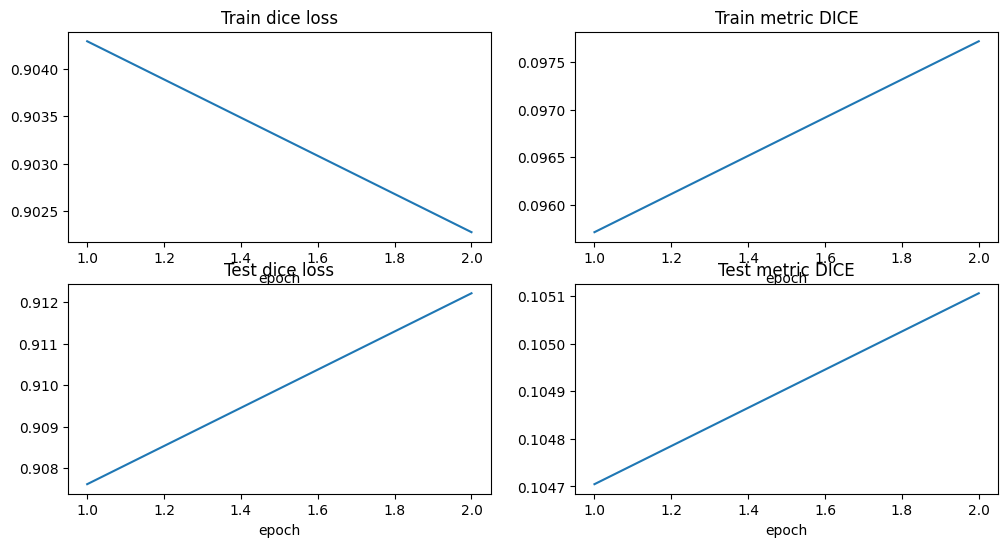

In [16]:
from utils.view import  plt_metrices

path = OUT_DIR+ "unet/"
if (os.path.exists(path)):
    plt_metrices(path)

In [17]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm


model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=( 64, 128, 256,512), 
    strides=(2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

In [19]:
import os.path

path = OUT_DIR+ "unet/"+ "best_metric_model.pth"

if (os.path.exists(path)):
    model.load_state_dict(torch.load(
        os.path.join(path)))
# model.eval()

## Modified Net

In [ ]:
from utils.view import  plt_metrices

path = OUT_DIR+ "mnet/"
if (os.path.exists(path)):
    plt_metrices(path)

In [ ]:
from Models.ModifiedNet import MNet

model = MNet().to(device)

In [ ]:
import os.path

path = OUT_DIR+ "mnet/"+ "best_metric_model.pth"

if (os.path.exists(path)):
    model.load_state_dict(torch.load(
        os.path.join(path)))
# model.eval()

## UNet 3+

In [ ]:
from utils.view import  plt_metrices

path = OUT_DIR+ "unet_3plus/"
if (os.path.exists(path)):
    plt_metrices(path)

In [ ]:
from Models.Unet_TriplePlus import U_net_TriplePlus

model = U_net_TriplePlus(1,1).to(device=device)

In [ ]:
import os.path

path = OUT_DIR+ "unet_3plus/"+ "best_metric_model.pth"

if (os.path.exists(path)):
    model.load_state_dict(torch.load(
        os.path.join(path)))
# model.eval()

# Plot

In [20]:
spatial_size = [128,128,16]

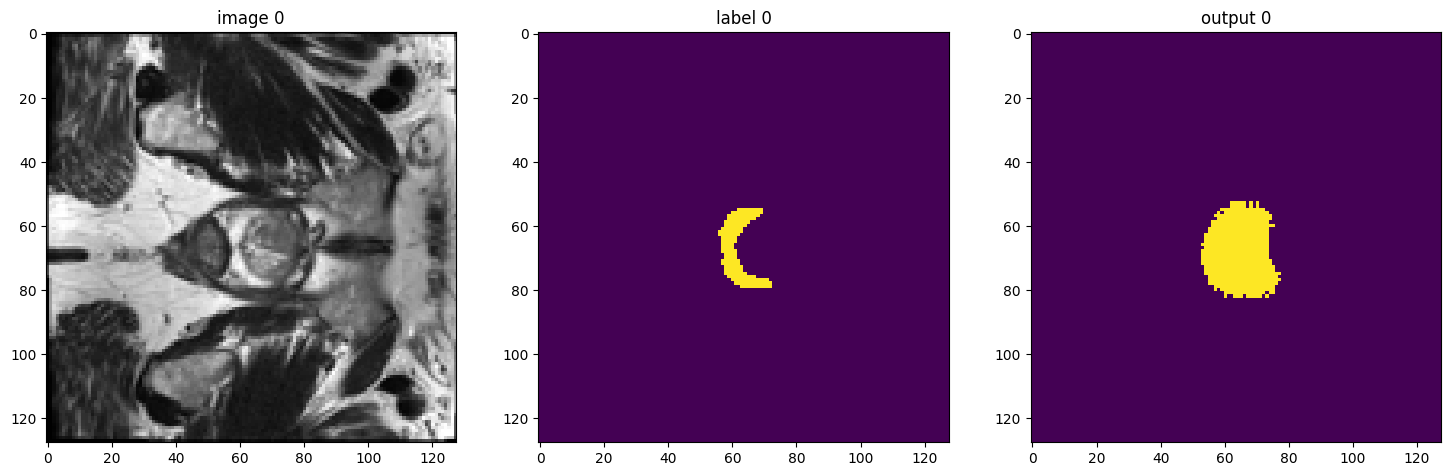

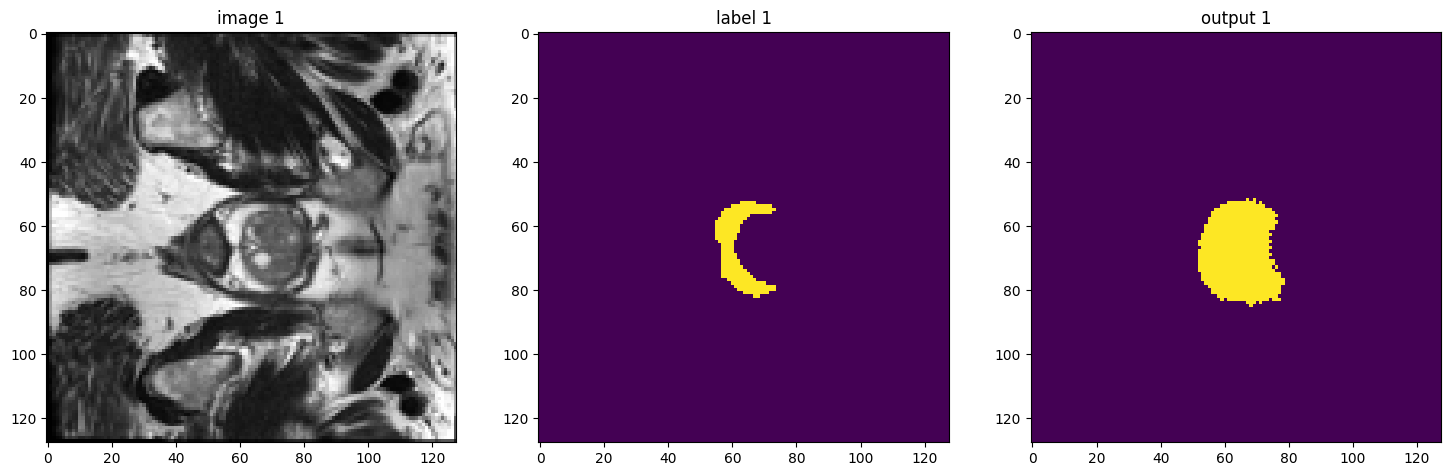

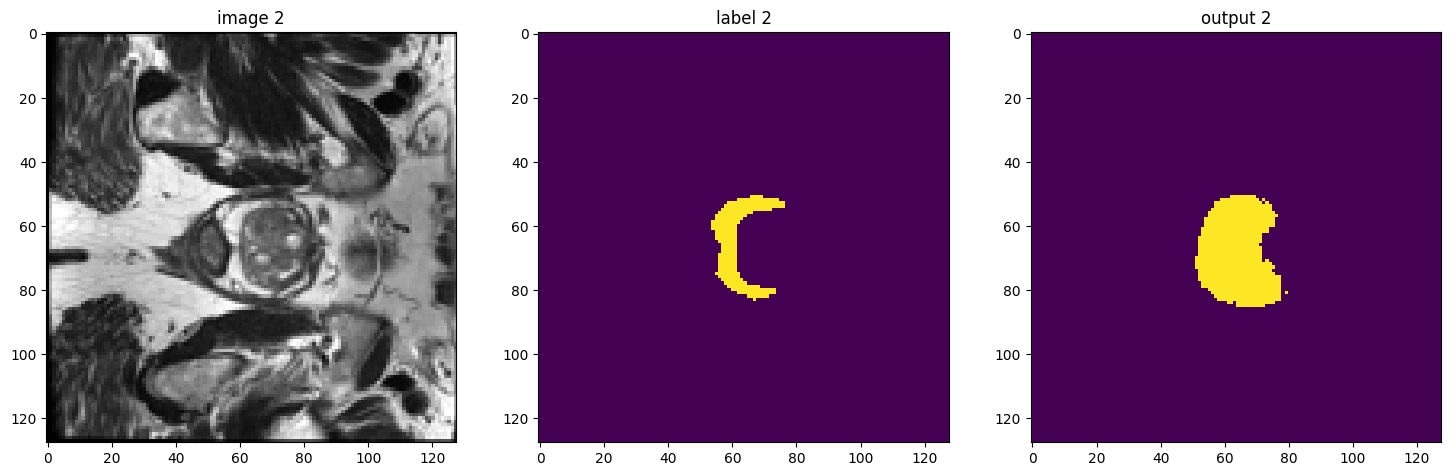

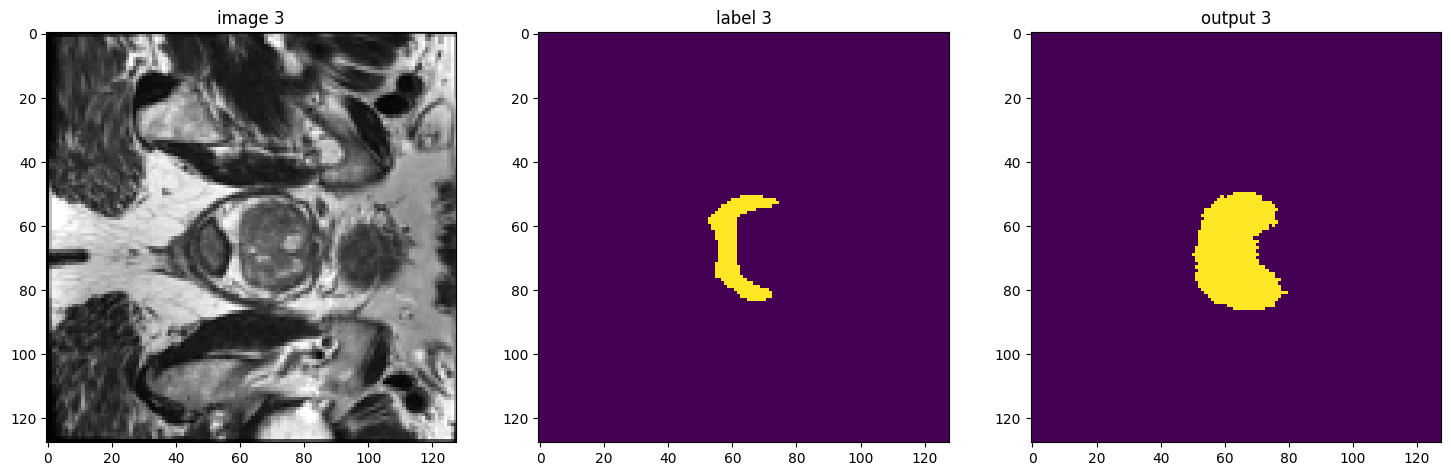

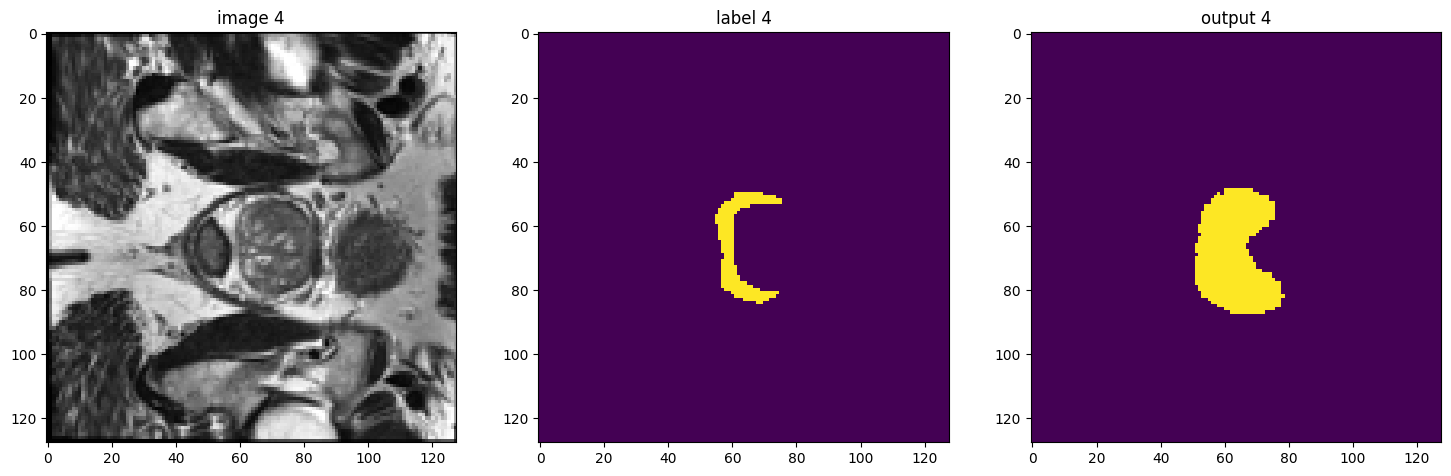

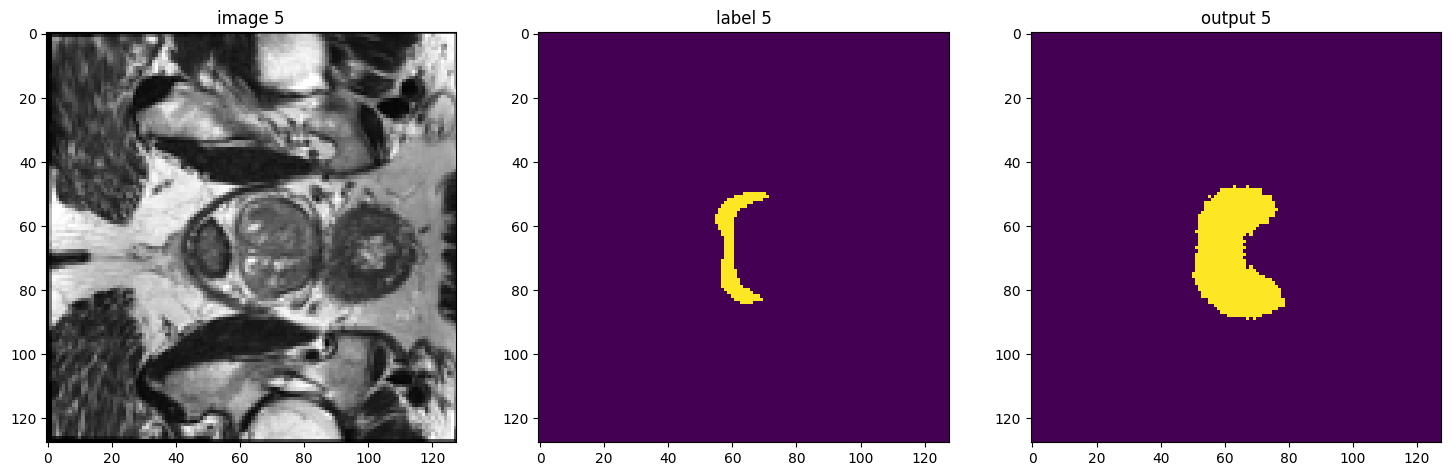

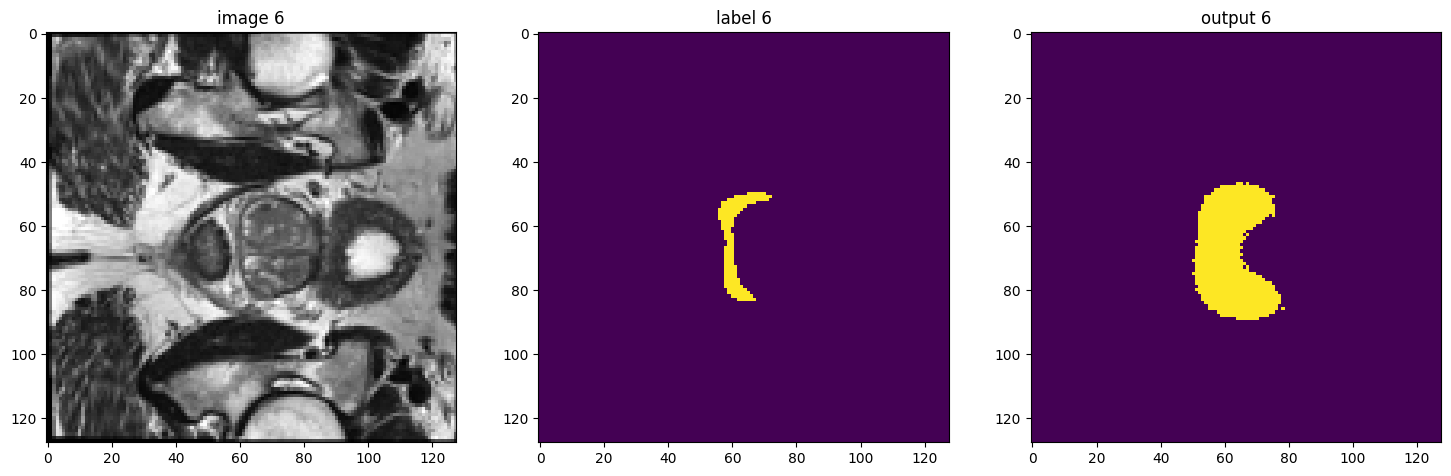

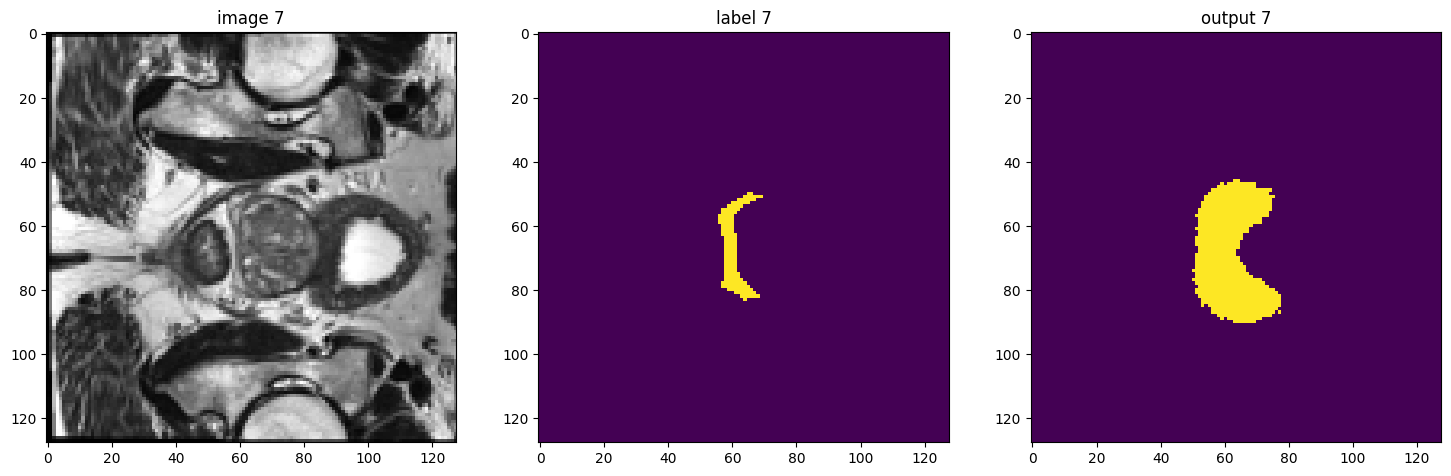

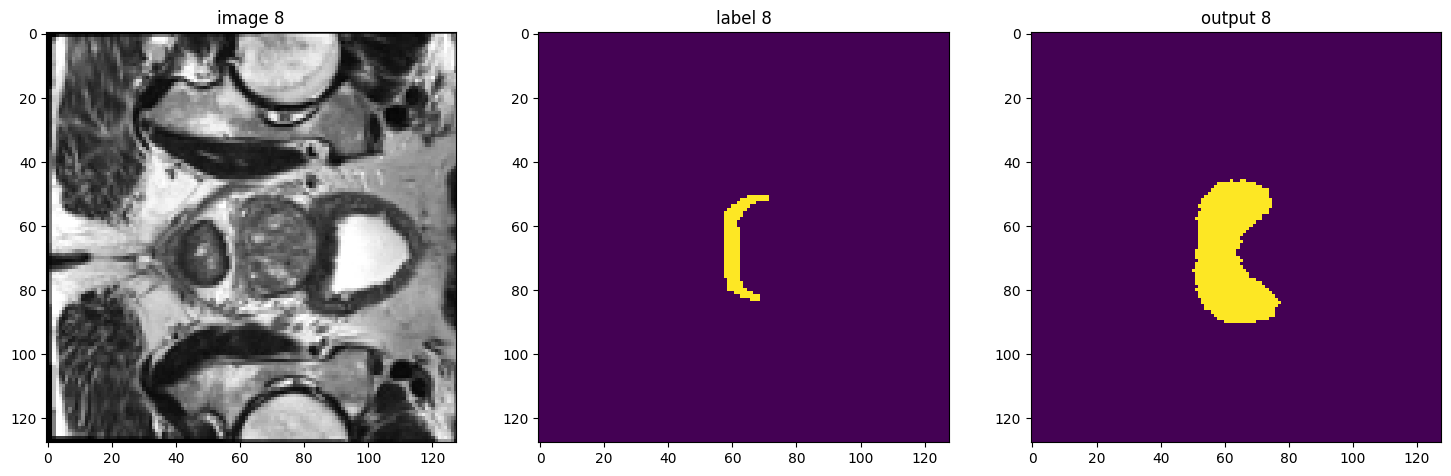

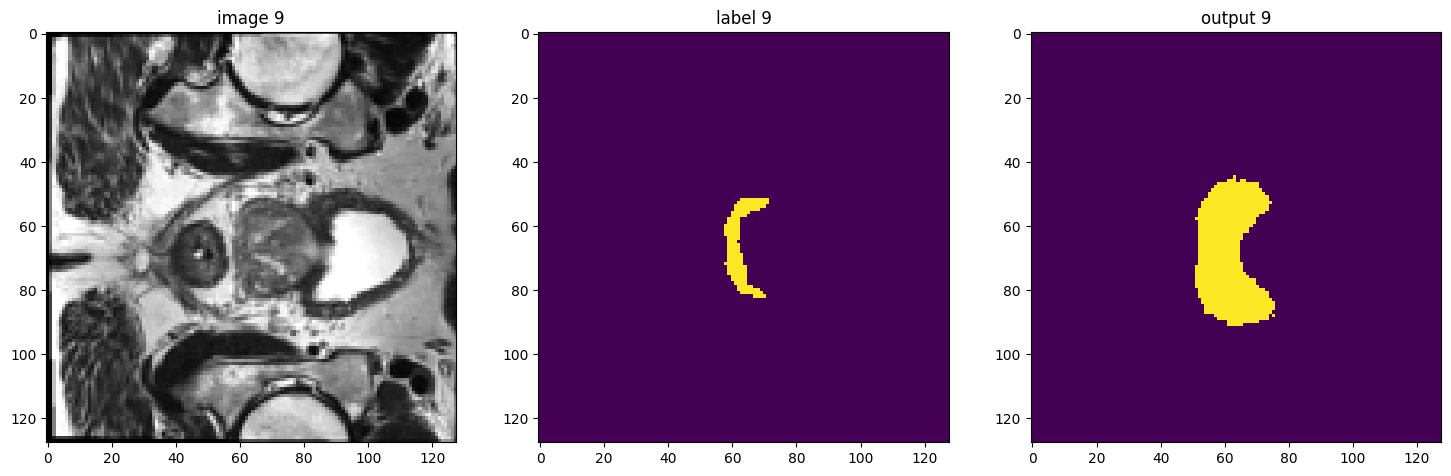

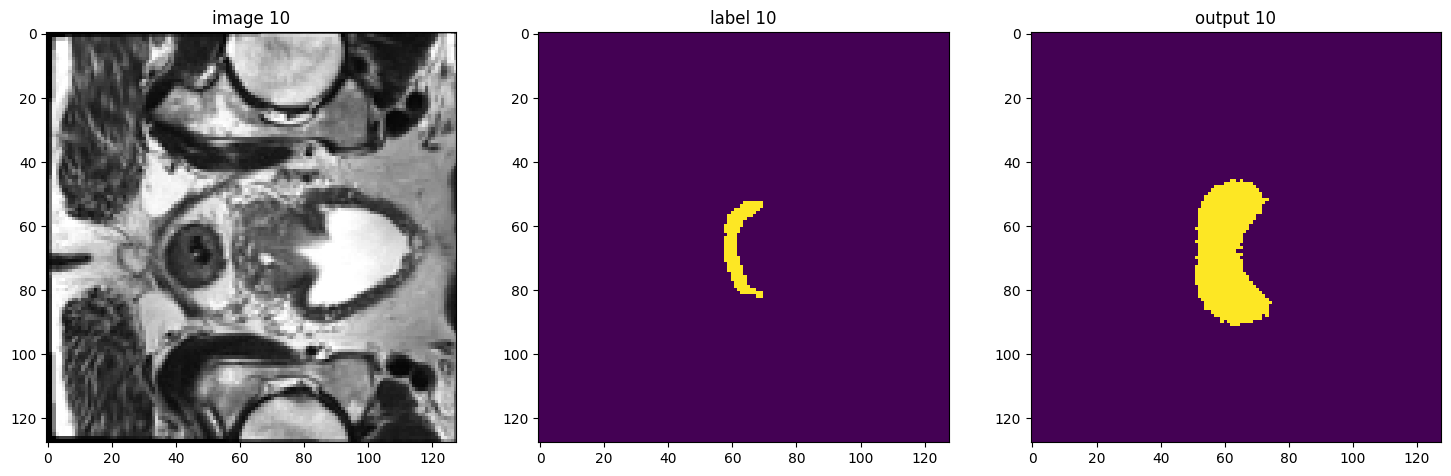

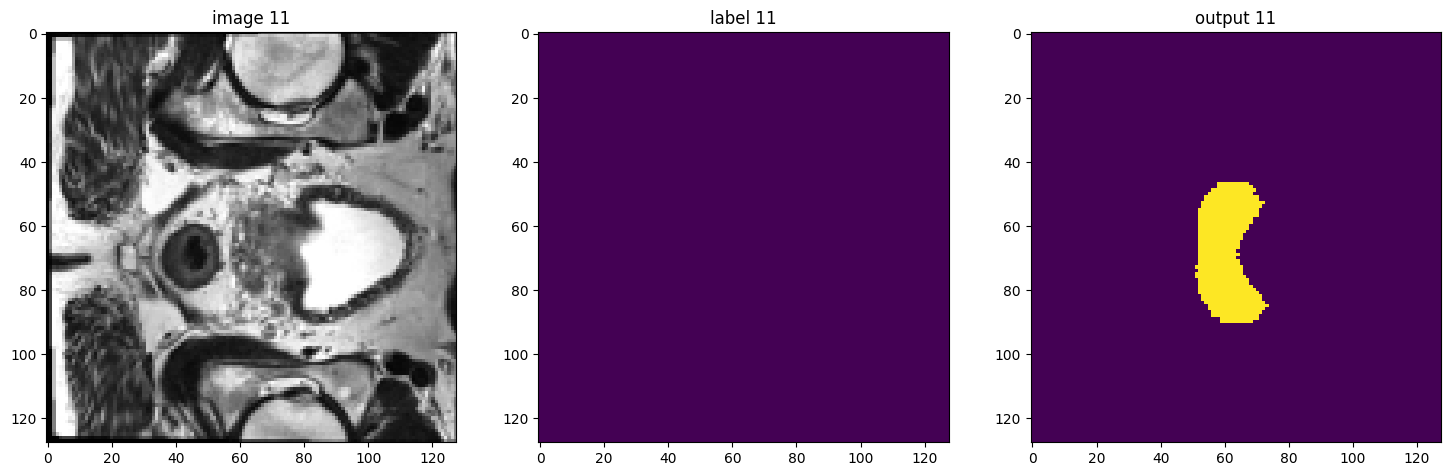

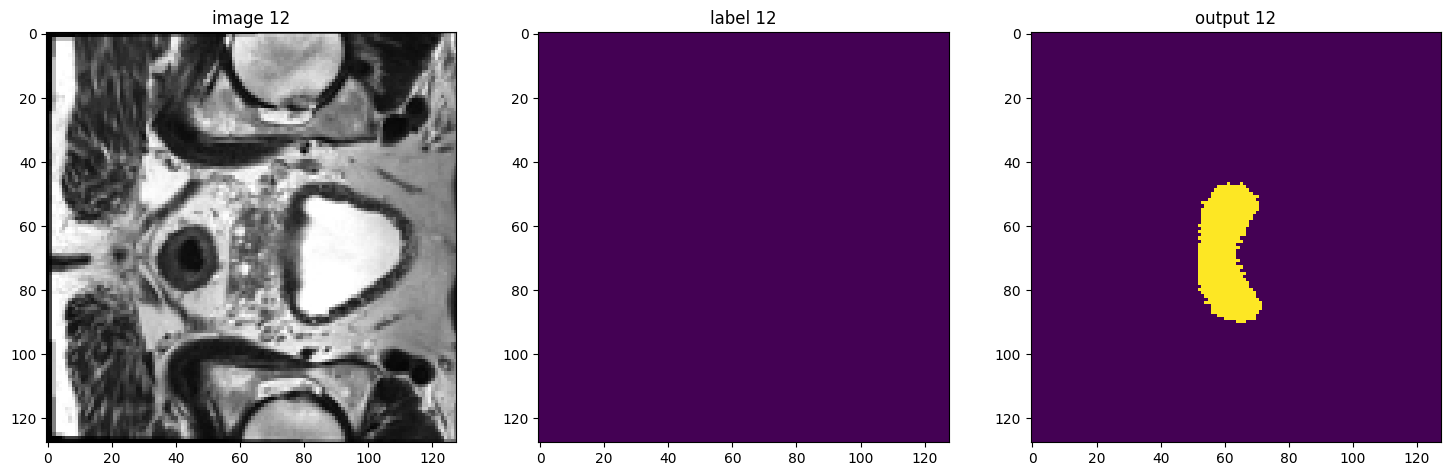

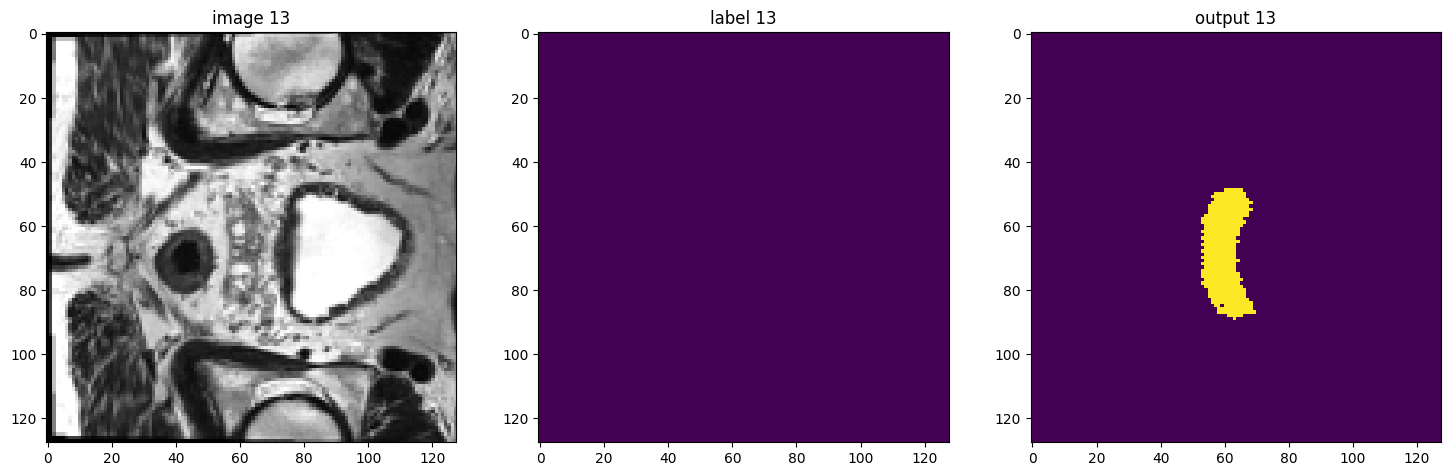

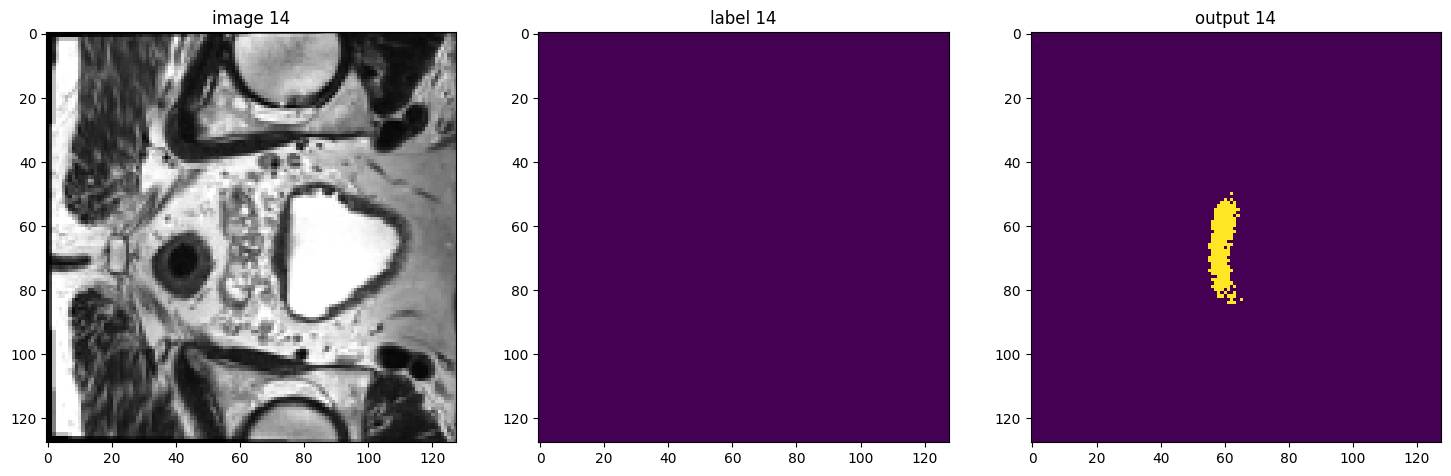

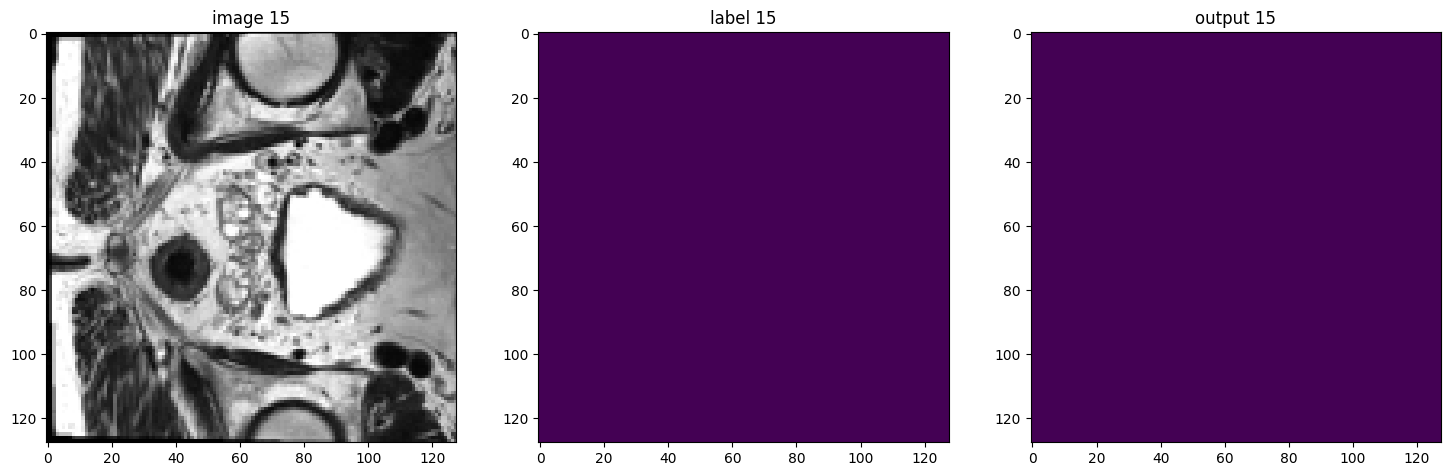

In [21]:
sw_batch_size = 4
roi_size = spatial_size
with torch.no_grad():
    test_patient = first(test_loader)
    t_volume = test_patient['image']
    #t_segmentation = test_patient['seg']
    
    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.8
        
    for i in range(spatial_size[2]):
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_patient["image"][0, 0, :, :, i], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_patient["label"][0, 0, :, :, i] != 0)
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(test_outputs.detach().cpu()[0, 0, :, :, i])
        plt.show()